In [1]:
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import itertools
from collections import defaultdict

In [5]:
subprocess.check_call(["scp", "cms2018.gdml", "emmet:"])

0

## Run interactively

In [9]:
print(json.dumps({
    'image': {
        'lower_left': [-500, 0, -1000],
        'upper_right': [500, 0, 1000],
        'rightward_ax': [0, 0, 1],
        'vertical_pixels': 256,
    },
    'cuda_stack_size': 32768,
    'input': 'cms2018.gdml',
    'output': 'cms-oneray.bin'
}, indent=1))

{
 "image": {
  "lower_left": [
   -500,
   0,
   -1000
  ],
  "upper_right": [
   500,
   0,
   1000
  ],
  "rightward_ax": [
   0,
   0,
   1
  ],
  "vertical_pixels": 256
 },
 "cuda_stack_size": 32768,
 "input": "cms2018.gdml",
 "output": "cms-oneray.bin"
}


In [7]:
inp = {
    'image': {
        'lower_left': [-500, 0, -1000],
        'upper_right': [500, 0, 1000],
        'rightward_ax': [0, 0, 1],
        'vertical_pixels': 256,
    },
    'cuda_stack_size': 32768,
    'input': 'cms2018.gdml',
    'output': 'cms.bin'
}

results = subprocess.check_output([
    "ssh", "emmet", "~/.local/src/celeritas/build/app/demo-rasterizer", "-"],
    input=json.dumps(inp).encode())
results = json.loads(results.decode())


CalledProcessError: Command '['ssh', 'emmet', '~/.local/src/celeritas/build/app/demo-rasterizer', '-']' returned non-zero exit status 255.

In [9]:
results = run(256, 256*128, 2)
print("Completed", results['run']['num_tracks'], "tracks in", results['result']['total_time'], "seconds")

Completed 16777216 tracks in 2.258554553 seconds


In [10]:
tally = results['run']['tally_grid']
grid = np.arange(tally['size'] + 1) * tally['delta'] + tally['front']

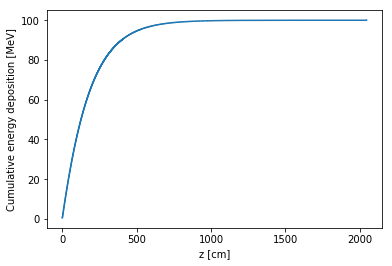

In [11]:
edep = np.array(results['result']['edep'])
(fig, ax) = plt.subplots()
ax.plot(grid[:-1], np.cumsum(edep), drawstyle='steps-post')
#ax.plot(grid, (1 - np.exp(-xs_value * grid)), color='r')
ax.set_xlabel('z [cm]')
ax.set_ylabel('Cumulative energy deposition [MeV]');
fig.savefig(f"edep-accum-{initial_energy:.0f}MeV.png", dpi=300)

In [12]:
# Export to numpy
np.savetxt(f"edep-{initial_energy:.0f}MeV-{tally['delta']}cm.txt", edep)

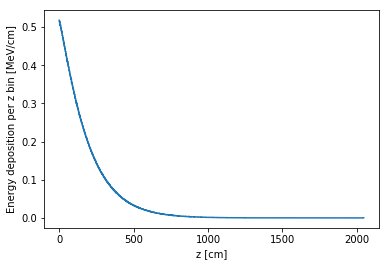

In [13]:
edep_per_dist = edep / tally['delta']
(fig, ax) = plt.subplots()
ax.plot(grid[:-1], edep_per_dist, drawstyle='steps-post')
ax.set_xlabel('z [cm]')
ax.set_ylabel('Energy deposition per z bin [MeV/cm]');
fig.savefig(f"edep-{initial_energy:.0f}MeV.png", dpi=300)

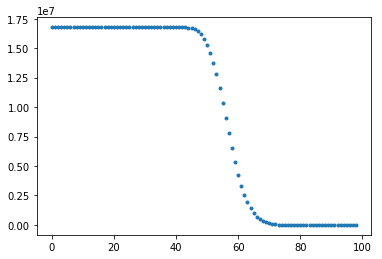

In [14]:
alive = np.array(results['result']['alive'])
time = np.array(results['result']['time'])
plt.plot(alive, '.');

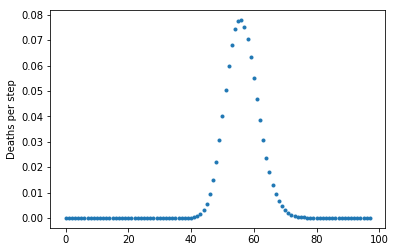

In [15]:
plt.plot(np.diff(-alive/alive[0]), '.')
plt.ylabel('Deaths per step');

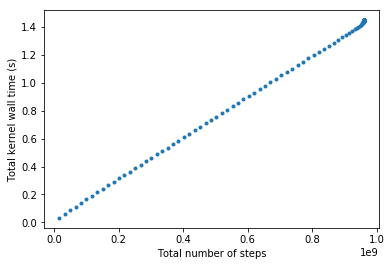

In [16]:
plt.plot(np.cumsum(alive[:-1]), np.cumsum(time), '.');
plt.xlabel("Total number of steps")
plt.ylabel("Total kernel wall time (s)");

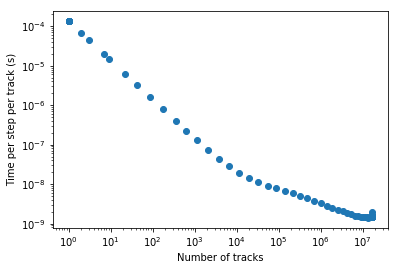

In [17]:
# Time per track
(fig, ax) = plt.subplots(1, 1, subplot_kw=dict(xscale='log', yscale='log'))
ax.scatter(alive[:-1], time / alive[:-1])
ax.set_xlabel('Number of tracks')
ax.set_ylabel('Time per step per track (s)');

## Time scaling

In [18]:
def run_one_scaling(scaling_results, *args):
    try:
        result = run(*args)
    except subprocess.CalledProcessError:
        print("FAILED to run:", args)
        return

    scaling_results['steps'].append(sum(result['result']['alive']))
    scaling_results['kernel_time'].append(sum(result['result']['time']))
    scaling_results['total_time'].append(result['result']['total_time'])
    scaling_results['block_size'].append(result['grid_params']['block_size'])
    scaling_results['grid_size'].append(result['grid_params']['grid_size'])
    scaling_results['tracks'].append(result['run']['num_tracks'])

In [33]:
scaling_results = defaultdict(list)

# Note: block size of 1024 always fails due to insufficient registers
for (bs, gs, tpt) in itertools.product(
        [128, 256, 512],
        [64, 128, 256, 512, 1024, 2048, 4096],
        [1, 2, 4, 8, 16]):
    run_one_scaling(scaling_results, bs, gs, tpt)

In [34]:
scaling_results = {k: np.array(v) for k, v in scaling_results.items()}

In [65]:
with open('scaling.json', 'w') as f:
    json.dump({k: v.tolist() for k, v in scaling_results.items()}, f, indent=1)

In [35]:
from matplotlib.colors import LogNorm

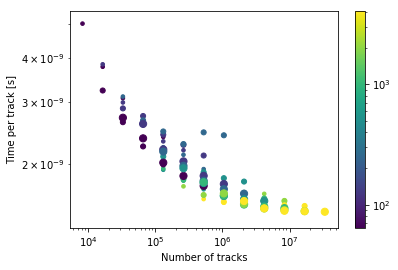

In [66]:
(fig, ax) = plt.subplots(1, 1, subplot_kw=dict(xscale='log', yscale='log'))
time_per_step = scaling_results['kernel_time'] / scaling_results['steps']
time_per_track = scaling_results['kernel_time'] / scaling_results['tracks']
num_threads = scaling_results['block_size'] * scaling_results['grid_size']
tracks_per_thread = scaling_results['tracks'] // num_threads
single_thread = (tracks_per_thread == 1)
scat = ax.scatter(scaling_results['tracks'], time_per_step,
          c=scaling_results['grid_size'], norm=LogNorm(),
          s=scaling_results['block_size'] / 10)
fig.colorbar(scat)
ax.set_xlabel('Number of tracks')
ax.set_ylabel('Time per track [s]');

In [45]:
import pandas as pd

In [56]:
df = pd.DataFrame(scaling_results)
df.index = pd.MultiIndex.from_arrays([df['tracks'],df['block_size'], df['grid_size']])
df.sort_index(inplace=True)

In [59]:
time_per_track = df['kernel_time'] / df['tracks']

In [64]:
time_per_track.xs(2**17, level='tracks')

block_size  grid_size
128         64           1.366253e-07
            128          1.327071e-07
            256          1.277243e-07
            512          1.101283e-07
            1024         1.110677e-07
256         64           1.140754e-07
            128          1.386924e-07
            256          1.416165e-07
            512          1.201337e-07
512         64           1.153979e-07
            128          1.258362e-07
            256          1.241151e-07
dtype: float64

## 1 MeV distributions

From the unit test.

In [27]:
nsamples = 10000
eps = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 285, 235, 208, 220, 208, 183, 165, 177, 147, 135, 154, 139, 148, 150, 137, 134, 124, 132, 112, 126, 112, 122, 105, 124, 99, 98, 105, 110, 124, 109, 110, 108, 109, 111, 109, 102, 111, 94, 104, 126, 88, 107, 103, 97, 104, 116, 122, 107, 107, 114, 109, 98, 103, 110, 106, 104, 105, 109, 108, 102, 100, 115, 110, 118, 116, 117, 101, 121, 123, 100, 118, 118, 118, 107, 133, 120, 127, 113, 113])
costheta = np.array([49, 51, 40, 45, 49, 52, 52, 45, 54, 58, 52, 39, 38, 45, 60, 46, 49, 47, 34, 49, 38, 52, 58, 62, 59, 53, 50, 35, 44, 61, 58, 47, 50, 48, 59, 57, 50, 56, 54, 49, 50, 39, 56, 57, 68, 49, 64, 56, 59, 67, 75, 55, 77, 69, 76, 66, 60, 76, 80, 67, 74, 68, 79, 75, 77, 90, 80, 82, 96, 82, 82, 85, 94, 126, 117, 105, 111, 119, 136, 126, 137, 117, 157, 169, 144, 163, 167, 214, 203, 222, 202, 233, 257, 262, 289, 320, 353, 365, 412, 450])

In [28]:
grid = np.linspace(0, 1, len(eps) + 1)

Text(0.5, 0, '$E_{\\mathrm{out}} / E_{\\mathrm{in}}$')

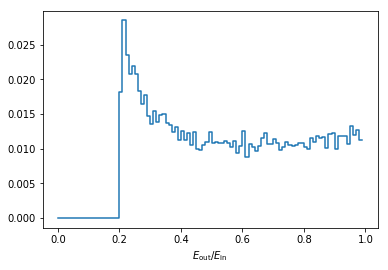

In [29]:
plt.plot(grid[:-1], eps / nsamples, drawstyle="steps-post")
plt.xlabel(r"$E_{\mathrm{out}} / E_{\mathrm{in}}$")

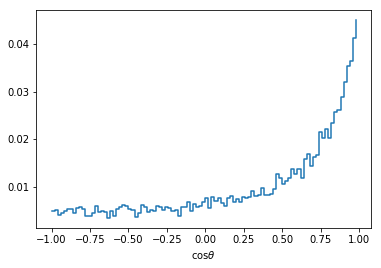

In [30]:
plt.plot((grid * 2 - 1)[:-1], costheta / nsamples, drawstyle="steps-post")
plt.xlabel(r"$\cos \theta$");